In [2]:
# base
import pandas as pd
from pandas.api.types import CategoricalDtype, is_categorical_dtype
import numpy as np
import scanpy.api as sc
import scanpy.external
import anndata as ad
import scipy.stats as ss
import sys


#plotting
from plotnine import *
import plotnine
import matplotlib as mp

# ingest data and update labels
adata = sc.read_h5ad('/mnt/ibm_lg/daniel_le/data/covid/comet/TA_COMET_10x.h5ad')

Leiden_1_Type = [
    'Neutrophil', 'Mono/Macro','Epithelial','T/NK','Mono/Macro','Mono/Macro','Mono/Macro','Epithelial','LowQuality','Mono/Macro','Mono/Macro',
    'Epithelial','Mono/Macro','Epithelial','Epithelial','Epithelial','Epithelial','Epithelial','Mono/Macro','Epithelial','Epithelial',
    'T/NK','Neutrophil', 'Epithelial','Epithelial','Epithelial','Epithelial','Epithelial','Epithelial','Epithelial','Epithelial',
    'B', 'Epithelial']

leiden_1_dict = {}
for idx, x in enumerate(Leiden_1_Type):
    leiden_1_dict[str(idx)] = x
    
adata.obs['leiden_1_class'] = adata.obs['leiden_1'].map(leiden_1_dict)

# metrics
metrics = ['log1p_n_genes_by_counts', 
           'log1p_total_counts', 
           'pct_counts_in_top_50_genes', 
           'percent_ribo', 
           'percent_mito',
          ]
occupants = ['patientID_415-xxxx']
qc_metrics = ['log1p_n_genes_by_counts', 'percent_mito',]
adata_df = adata.obs.loc[:,metrics+occupants]

# ref: https://github.com/oliviaguest/gini
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

def prepare_dataframe(adata, var_names, groupby=None, use_raw=None, log=False, num_categories=7):
    """
    ### FROM scanpy ###
    
    Given the anndata object, prepares a data frame in which the row index are the categories
    defined by group by and the columns correspond to var_names.
    Parameters
    ----------
    adata : :class:`~anndata.AnnData`
        Annotated data matrix.
    var_names : `str` or list of `str`
        `var_names` should be a valid subset of  `adata.var_names`.
    groupby : `str` or `None`, optional (default: `None`)
        The key of the observation grouping to consider. It is expected that
        groupby is a categorical. If groupby is not a categorical observation,
        it would be subdivided into `num_categories`.
    log : `bool`, optional (default: `False`)
        Use the log of the values
    use_raw : `bool`, optional (default: `None`)
        Use `raw` attribute of `adata` if present.
    num_categories : `int`, optional (default: `7`)
        Only used if groupby observation is not categorical. This value
        determines the number of groups into which the groupby observation
        should be subdivided.
    Returns
    -------
    Tuple of `pandas.DataFrame` and list of categories.
    """
    from scipy.sparse import issparse
#     sanitize_anndata(adata)
    if use_raw is None and adata.raw is not None: use_raw = True
    if isinstance(var_names, str):
        var_names = [var_names]

    if groupby is not None:
        if groupby not in adata.obs_keys():
            raise ValueError('groupby has to be a valid observation. Given value: {}, '
                             'valid observations: {}'.format(groupby, adata.obs_keys()))

    if use_raw:
        matrix = adata.raw[:, var_names].X
    else:
        matrix = adata[:, var_names].X

    if issparse(matrix):
        matrix = matrix.toarray()
    if log:
        matrix = np.log1p(matrix)

    obs_tidy = pd.DataFrame(matrix, columns=var_names)
    if groupby is None:
        groupby = ''
        categorical = pd.Series(np.repeat('', len(obs_tidy))).astype('category')
    else:
        if not is_categorical_dtype(adata.obs[groupby]):
            # if the groupby column is not categorical, turn it into one
            # by subdividing into  `num_categories` categories
            categorical = pd.cut(adata.obs[groupby], num_categories)
        else:
            categorical = adata.obs[groupby]

    obs_tidy.set_index(categorical, groupby, inplace=True)
    categories = obs_tidy.index.categories

    return categories, obs_tidy

def kde_scipy(x, x_grid, bandwidth=0.1, **kwargs):
    """ref = https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/"""
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    try:
        kde = ss.gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
        return_vals = kde.evaluate(x_grid)
    except:
        return_vals = np.zeros(x_grid.shape)
        return_vals[:10] = 1
    return return_vals

/home/daniel_le/anaconda3/lib/python3.7/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,
/home/daniel_le/anaconda3/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/home/daniel_le/anaconda3/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


## metadata analysis

In [153]:
pd.options.display.max_columns = 50
pd.options.display.max_rows = 100

metadata = (pd.read_csv('/mnt/ibm_lg/daniel_le/data/covid/comet/DL20200609_metadata',
                       index_col=0,
                      )
            .replace('PHI',np.nan)
            .dropna(how='all', axis=0)
            .dropna(how='all', axis=1)
            .drop(['One Liner'], axis=1)
            .sort_values(['COVID-19 Status','Death (Y/N)'])
           )
# binary categories
metadata['COVID_Rx_steroid (Y/N)'] = ['Y' if 'steroid' in x.lower() else 'N' for x in metadata['Other COVID Rx']]
metadata['COVID_Rx_HCQ (Y/N)'] = ['Y' if 'hcq' in x.lower() else 'N' for x in metadata['Other COVID Rx']]
metadata['COVID_Rx_pred (Y/N)'] = ['Y' if 'pred' in x.lower() else 'N' for x in metadata['Other COVID Rx']]
metadata['COVID_Rx_Convalescent (Y/N)'] = ['Y' if 'convalescent' in x.lower() else 'N' for x in metadata['Other COVID Rx']]
metadata['COVID_Rx_azithro (Y/N)'] = ['Y' if 'azithro' in x.lower() else 'N' for x in metadata['Other COVID Rx']]
metadata['COVID_Rx_MSC (Y/N)'] = ['Y' if 'stem' in x.lower() \
                                  else 'Y' if 'msc' in x.lower() \
                                  else 'N' for x in metadata['Other COVID Rx']]
metadata['COVID_Rx_nitazoxanide (Y/N)'] = ['Y' if 'nitazoxanide' in x.lower() else 'N' for x in metadata['Other COVID Rx']]
metadata['COVID_Rx_toci (Y/N)'] = ['Y' if 'toci' in x.lower() else 'N' for x in metadata['Other COVID Rx']]
metadata['COVID_Rx_Kaletra (Y/N)'] = ['Y' if 'kaletra' in x.lower() else 'N' for x in metadata['Other COVID Rx']]

metadata['Other_resp_micro (Y/N)'] = ['Y' if x != 'None' else 'N' for x in metadata['Other resp  micro']]
metadata['Other_infection (Y/N)'] = ['Y' if x != 'None' else 'N' for x in metadata['Other infection ']]

metadata['COVID_status_(T/F)'] = ['Positive' in x for x in metadata['COVID-19 Status']]
metadata['COVID_test_(T/F)'] = ['Positive' in x for x in metadata['COVID test result']]

# clean Y/N
for col in metadata.columns:
    if col.endswith('(Y/N)'):
        metadata[col] = [x[0] for x in metadata[col]]
        metadata[col] = [x=='Y' for x in metadata[col]]
        
# clean labels
for col in metadata.columns:
    metadata[col] = [x.strip() if isinstance(x,str) else x for x in metadata[col]]

# keep columns
metadata_trimmed = metadata.loc[:, [
    # status
    'COVID_status_(T/F)','COVID_test_(T/F)','Mortality (days from admission)', 'Death (Y/N)',
    # demographics
    'Age', 'Gender', 'Race', 'Ethnicity', 'Height (admit, cm)','Weight (admit, kg)', 'BMI (admit)',
    # existing coditions                                
    'Pregnant (Y/N)', 'DM (Y/N)','HTN (Y/N)', 'COPD (Y/N)', 'Asthma (Y/N)', 'Previous ICS (Y/N)','Cancer (Y/N)', 'IS (Y/N)', 'Autoimmune (Y/N)', 'Transplant (Y/N)',
    # treatment
    'Remdes (Y/N)','COVID_Rx_steroid (Y/N)','COVID_Rx_HCQ (Y/N)', 'COVID_Rx_pred (Y/N)','COVID_Rx_Convalescent (Y/N)', 'COVID_Rx_azithro (Y/N)','COVID_Rx_MSC (Y/N)', 'COVID_Rx_nitazoxanide (Y/N)','COVID_Rx_toci (Y/N)', 'COVID_Rx_Kaletra (Y/N)',
    # presentation
    'Pressors (Y/N)', 'Proning (Y/N)', 'iNO (Y/N)', 'ECMO (Y/N)','Thrombosis (Y/N)','Other_infection (Y/N)', 'Other_resp_micro (Y/N)',
    ]]

# update colnames
metadata_trimmed.columns = ['{}_(T/F)'.format(x[:-6]) if x.endswith('(Y/N)') else x for x in metadata_trimmed.columns ]
metadata_trimmed.columns = [x.replace(' ','_') for x in metadata_trimmed.columns]

metadata_trimmed

,COVID_status_(T/F),COVID_test_(T/F),Mortality_(days_from_admission),Death_(T/F),Age,Gender,Race,Ethnicity,"Height_(admit,_cm)","Weight_(admit,_kg)",BMI_(admit),Pregnant_(T/F),DM_(T/F),HTN_(T/F),COPD_(T/F),Asthma_(T/F),Previous_ICS_(T/F),Cancer_(T/F),IS_(T/F),Autoimmune_(T/F),Transplant_(T/F),Remdes_(T/F),COVID_Rx_steroid_(T/F),COVID_Rx_HCQ_(T/F),COVID_Rx_pred_(T/F),COVID_Rx_Convalescent_(T/F),COVID_Rx_azithro_(T/F),COVID_Rx_MSC_(T/F),COVID_Rx_nitazoxanide_(T/F),COVID_Rx_toci_(T/F),COVID_Rx_Kaletra_(T/F),Pressors_(T/F),Proning_(T/F),iNO_(T/F),ECMO_(T/F),Thrombosis_(T/F),Other_infection_(T/F),Other_resp_micro_(T/F)
Element,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1009.0,False,False,NaN,False,67.0,M,White,Not Hispanic,171.0,54.9,18.775008,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,True
1010.0,False,False,NaN,False,50.0,F,Black,Not Hispanic,177.8,57.7,18.252077,False,False,True,False,False,True,False,True,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,True,True
1016.0,False,False,NaN,False,63.0,F,Asian,Not Hispanic,157.5,64.4,25.961199,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,True
1027.0,False,False,NaN,False,64.0,F,White,Not Hispanic,160.0,57.7,22.539062,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,True,True,True
1028.0,False,False,NaN,False,33.0,M,White,Not Hispanic,157.5,40.4,16.286218,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,True
1065.0,False,False,NaN,False,41.0,F,Asian,Not Hispanic,157.5,49.9,20.115898,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True
1021.0,False,False,8.0,True,77.0,F,Other,Not Hispanic,160.0,107.9,42.148438,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,True
1001.0,True,True,NaN,False,34.0,F,White,Not Hispanic,165.1,97.2,35.659243,True,True,False,False,True,True,False,False,False,False,True,False,True,True,False,False,False,False,False,False,True,False,False,False,False,True,True
1002.0,True,True,NaN,False,79.0,M,Other,Not Hispanic,190.0,71.0,19.667590,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,True


### numeric categories

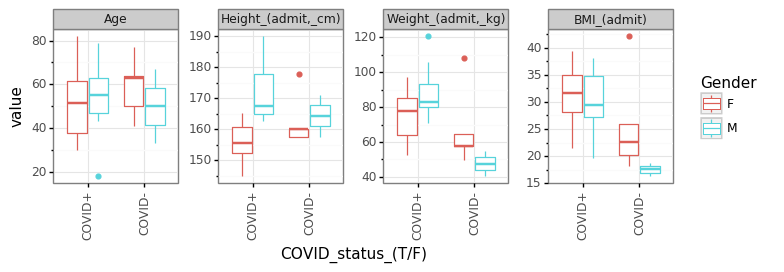

<ggplot: (8758049873737)>


,variable,COVID_status_(T/F),Gender,count,mean,50%
0,Age,COVID+,F,8,51.500000,51.500000
1,Age,COVID+,M,13,55.076923,55.000000
2,Age,COVID-,F,5,59.000000,63.000000
3,Age,COVID-,M,2,50.000000,50.000000
4,"Height_(admit,_cm)",COVID+,F,8,156.162500,155.450000
5,"Height_(admit,_cm)",COVID+,M,13,171.546154,167.600000
6,"Height_(admit,_cm)",COVID-,F,5,162.560000,160.000000
7,"Height_(admit,_cm)",COVID-,M,2,164.250000,164.250000
8,"Weight_(admit,_kg)",COVID+,F,8,75.700000,78.000000
9,"Weight_(admit,_kg)",COVID+,M,13,87.353846,82.800000


In [154]:
pivot_1 = 'COVID_status_(T/F)'
pivot_2 = 'Gender'

target_vars = ['Age', 'Height_(admit,_cm)', 'Weight_(admit,_kg)', 'BMI_(admit)']

plot_df = metadata_trimmed.loc[:,[pivot_1,pivot_2,]+target_vars]
plot_df = pd.melt(plot_df, id_vars=[pivot_1,pivot_2])
plot_df['variable'] = (plot_df['variable']
                       .astype(str)
                       .astype(CategoricalDtype(target_vars, ordered=True))
                      )
plot_df[pivot_1] = ['COVID+' if x==True else 'COVID-' for x in plot_df[pivot_1]]

plotnine.options.figure_size=(8,2)
plot = (ggplot(plot_df)
        + theme_bw()
        + theme(panel_spacing_x = 0.4)
        + theme(axis_text_x = element_text(angle = 90))
        + geom_boxplot(aes(pivot_1,'value', color=pivot_2))
        + facet_wrap('~variable', scales='free',ncol=4)
       )
print(plot)

# tabular output
display_df = (plot_df
             .groupby(['variable',pivot_1,pivot_2])
             .describe()
             .loc[:, [('value','count'),
                     ('value','mean'),
                     ('value','50%'),
                    ]]
            )
display_df.columns = display_df.columns.get_level_values(1)
display_df = display_df.reset_index()
display_df['count'] = display_df['count'].astype(int)
display_df = display_df.sort_values(['variable',pivot_1,pivot_2])
display_df

### demographics

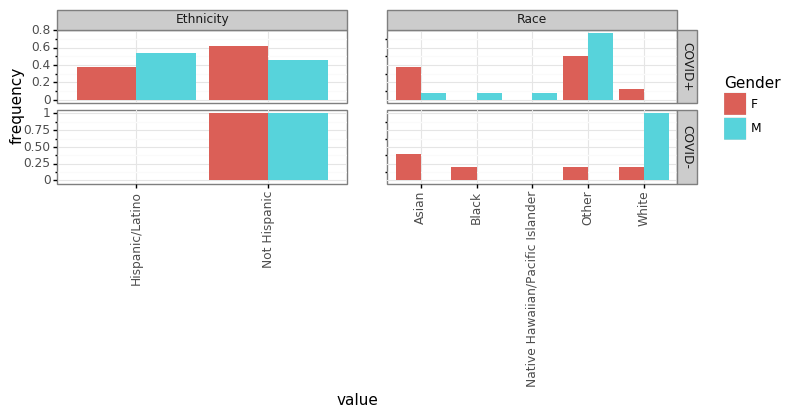

<ggplot: (8758049593777)>


,variable,value,COVID_status_(T/F),Gender,count
0,Ethnicity,Hispanic/Latino,COVID+,F,3
7,Ethnicity,Hispanic/Latino,COVID+,M,7
14,Ethnicity,Hispanic/Latino,COVID-,F,0
21,Ethnicity,Hispanic/Latino,COVID-,M,0
1,Ethnicity,Not Hispanic,COVID+,F,5
8,Ethnicity,Not Hispanic,COVID+,M,6
15,Ethnicity,Not Hispanic,COVID-,F,5
22,Ethnicity,Not Hispanic,COVID-,M,2
4,Race,Asian,COVID+,F,3
11,Race,Asian,COVID+,M,1


In [155]:
target_vars = ['Gender', 'Race', 'Ethnicity']
target_vars = [x for x in target_vars if x not in [pivot_1,pivot_2,]]

plot_df = metadata_trimmed.loc[:,[pivot_1,pivot_2]+target_vars]
plot_df = pd.melt(plot_df, id_vars=[pivot_1,pivot_2])
plot_df['variable'] = (plot_df['variable']
                       .astype(str)
                       .astype(CategoricalDtype(target_vars, ordered=True))
                      )
plot_df[pivot_1] = ['COVID+' if x==True else 'COVID-' for x in plot_df[pivot_1]]
display_df = pd.DataFrame(plot_df.groupby([pivot_1,pivot_2,'variable'])['value'].value_counts(normalize=False))
plot_df = pd.DataFrame(plot_df.groupby([pivot_1,pivot_2,'variable'])['value'].value_counts(normalize=True))
plot_df = (plot_df
           .rename(columns={'value':'frequency'})
           .reset_index()
          )

# create dummy categories
base_df = pd.DataFrame()
for x in set(plot_df[pivot_1]):
    for y in set(plot_df[pivot_2]):
        for z in set(plot_df['variable']):
            for zz in set(plot_df.query(f'variable == "{z}"')['value']):
                slice_df = pd.DataFrame({pivot_1:[x],
                                         pivot_2:[y],
                                         'variable':[z],
                                         'value':[zz],
                                        })
                base_df = base_df.append(slice_df)
                
plot_df = pd.merge(base_df, plot_df, 'left', [pivot_1,pivot_2,'variable','value',])
plot_df = plot_df.replace(np.nan, 0)

plotnine.options.figure_size=(8,2)
plot = (ggplot(plot_df)
        + theme_bw()
        + theme(panel_spacing_x = 0.4)
        + theme(axis_text_x = element_text(angle = 90))
        + geom_bar(aes('value','frequency',fill = pivot_2), stat='identity', position='dodge')
        + facet_grid(f'{pivot_1}~variable', scales='free')
       )
print(plot)

# tabular output
display_df = pd.merge(base_df, 
                      display_df.rename(columns = {'value':'count'}).reset_index(), 
                      'left', 
                      [pivot_1,pivot_2,'variable','value',])
display_df = display_df.replace(np.nan, 0)
display_df['count'] = display_df['count'].astype(int)
display_df = (display_df
              .loc[:, ['variable','value',pivot_1,pivot_2,'count']]
              .sort_values(['variable','value',pivot_1,pivot_2])
             )
display_df

### existing conditions

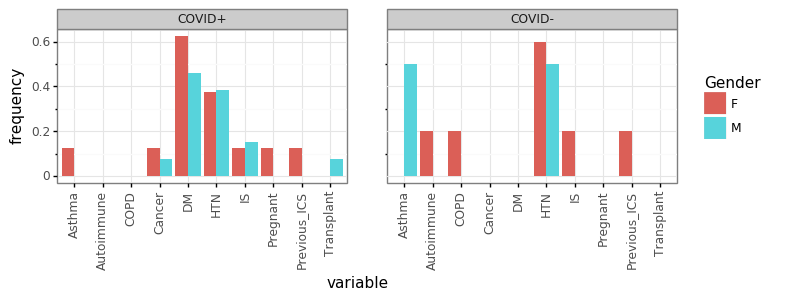

<ggplot: (8758049317645)>


,variable,value,COVID_status_(T/F),Gender,count
11,Asthma,False,COVID+,F,7
31,Asthma,False,COVID+,M,13
51,Asthma,False,COVID-,F,5
71,Asthma,False,COVID-,M,1
10,Asthma,True,COVID+,F,1
30,Asthma,True,COVID+,M,0
50,Asthma,True,COVID-,F,0
70,Asthma,True,COVID-,M,1
13,Autoimmune,False,COVID+,F,8
33,Autoimmune,False,COVID+,M,13


In [164]:
target_vars = ['Pregnant_(T/F)', 'DM_(T/F)', 'HTN_(T/F)', 'COPD_(T/F)',
              'Asthma_(T/F)', 'Previous_ICS_(T/F)', 'Cancer_(T/F)', 'IS_(T/F)',
              'Autoimmune_(T/F)', 'Transplant_(T/F)']
target_vars = [x for x in target_vars if x not in [pivot_1,pivot_2,]]

plot_df = metadata_trimmed.loc[:,[pivot_1,pivot_2,]+target_vars]
plot_df.columns = [x.split('_(T/F)')[0] if x not in [pivot_1,pivot_2] else x for x in plot_df.columns]
plot_df = pd.melt(plot_df, id_vars=[pivot_1,pivot_2])
plot_df['variable'] = (plot_df['variable']
                       .astype(str)
                       .astype(CategoricalDtype([x.split('_(T/F)')[0] for x in target_vars], ordered=True))
                      )
plot_df[pivot_1] = ['COVID+' if x==True else 'COVID-' for x in plot_df[pivot_1]]
display_df = pd.DataFrame(plot_df.groupby([pivot_1,pivot_2,'variable'])['value'].value_counts(normalize=False))
plot_df = pd.DataFrame(plot_df.groupby([pivot_1,pivot_2,'variable'])['value'].value_counts(normalize=True))
plot_df = (plot_df
           .rename(columns={'value':'frequency'})
           .reset_index()
          )

# create dummy categories
base_df = pd.DataFrame()
for x in set(plot_df[pivot_1]):
    for y in set(plot_df[pivot_2]):
        for z in set(plot_df['variable']):
            for zz in [True,False]:
                slice_df = pd.DataFrame({pivot_1:[x],
                                         pivot_2:[y],
                                         'variable':[z],
                                         'value':[zz],
                                        })
                base_df = base_df.append(slice_df)
                
plot_df = pd.merge(base_df, plot_df, 'left', [pivot_1,pivot_2,'variable','value',])
plot_df = plot_df.replace(np.nan, 0)

plotnine.options.figure_size=(8,2)
plot = (ggplot(plot_df[plot_df['value'] == True])
        + theme_bw()
        + theme(panel_spacing_x = 0.4)
        + theme(axis_text_x = element_text(angle = 90))
        + geom_bar(aes('variable','frequency',fill = pivot_2), stat='identity', position='dodge')
        + facet_grid(f'.~{pivot_1}', scales='free')
       )
print(plot)

# tabular output
display_df = pd.merge(base_df, 
                      display_df.rename(columns = {'value':'count'}).reset_index(), 
                      'left', 
                      [pivot_1,pivot_2,'variable','value',])
display_df = display_df.replace(np.nan, 0)
display_df['count'] = display_df['count'].astype(int)
display_df = (display_df
              .loc[:, ['variable','value',pivot_1,pivot_2,'count']]
              .sort_values(['variable','value',pivot_1,pivot_2])
             )
display_df


### treatments

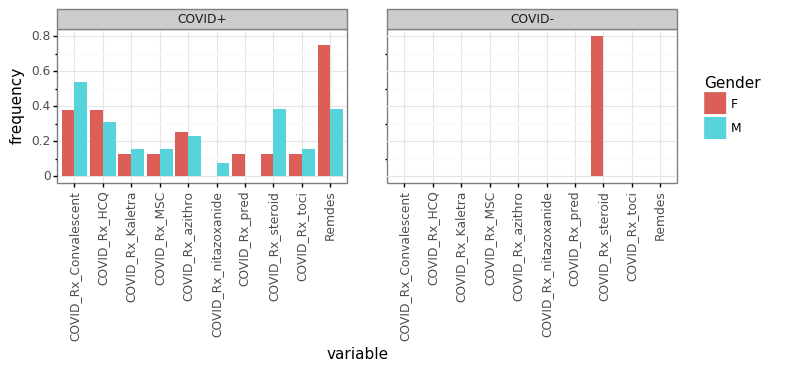

<ggplot: (8758050027665)>


,variable,value,COVID_status_(T/F),Gender,count
1,COVID_Rx_Convalescent,False,COVID+,F,5
21,COVID_Rx_Convalescent,False,COVID+,M,6
41,COVID_Rx_Convalescent,False,COVID-,F,5
61,COVID_Rx_Convalescent,False,COVID-,M,2
0,COVID_Rx_Convalescent,True,COVID+,F,3
20,COVID_Rx_Convalescent,True,COVID+,M,7
40,COVID_Rx_Convalescent,True,COVID-,F,0
60,COVID_Rx_Convalescent,True,COVID-,M,0
11,COVID_Rx_HCQ,False,COVID+,F,5
31,COVID_Rx_HCQ,False,COVID+,M,9


In [165]:
target_vars = ['Remdes_(T/F)','COVID_Rx_steroid_(T/F)', 'COVID_Rx_HCQ_(T/F)', 'COVID_Rx_pred_(T/F)',
               'COVID_Rx_Convalescent_(T/F)', 'COVID_Rx_azithro_(T/F)','COVID_Rx_MSC_(T/F)', 'COVID_Rx_nitazoxanide_(T/F)',
               'COVID_Rx_toci_(T/F)', 'COVID_Rx_Kaletra_(T/F)',]
target_vars = [x for x in target_vars if x not in [pivot_1,pivot_2,]]

plot_df = metadata_trimmed.loc[:,[pivot_1,pivot_2,]+target_vars]
plot_df.columns = [x.split('_(T/F)')[0] if x not in [pivot_1,pivot_2] else x for x in plot_df.columns]
plot_df = pd.melt(plot_df, id_vars=[pivot_1,pivot_2])
plot_df['variable'] = (plot_df['variable']
                       .astype(str)
                       .astype(CategoricalDtype([x.split('_(T/F)')[0] for x in target_vars], ordered = True))
                      )
plot_df[pivot_1] = ['COVID+' if x==True else 'COVID-' for x in plot_df[pivot_1]]
display_df = pd.DataFrame(plot_df.groupby([pivot_1,pivot_2,'variable'])['value'].value_counts(normalize=False))
plot_df = pd.DataFrame(plot_df.groupby([pivot_1,pivot_2,'variable'])['value'].value_counts(normalize=True))
plot_df = (plot_df
           .rename(columns={'value':'frequency'})
           .reset_index()
          )

# create dummy categories
base_df = pd.DataFrame()
for x in set(plot_df[pivot_1]):
    for y in set(plot_df[pivot_2]):
        for z in set(plot_df['variable']):
            for zz in [True,False]:
                slice_df = pd.DataFrame({pivot_1:[x],
                                         pivot_2:[y],
                                         'variable':[z],
                                         'value':[zz],
                                        })
                base_df = base_df.append(slice_df)
                
plot_df = pd.merge(base_df, plot_df, 'left', [pivot_1,pivot_2,'variable','value',])
plot_df = plot_df.replace(np.nan, 0)

plotnine.options.figure_size=(8,2)
plot = (ggplot(plot_df[plot_df['value'] == True])
        + theme_bw()
        + theme(panel_spacing_x = 0.4)
        + theme(axis_text_x = element_text(angle = 90))
        + geom_bar(aes('variable','frequency',fill = pivot_2), stat='identity', position='dodge')
        + facet_grid(f'.~{pivot_1}', scales='free')
       )
print(plot)

# tabular output
display_df = pd.merge(base_df, 
                      display_df.rename(columns = {'value':'count'}).reset_index(), 
                      'left', 
                      [pivot_1,pivot_2,'variable','value',])
display_df = display_df.replace(np.nan, 0)
display_df['count'] = display_df['count'].astype(int)
display_df = (display_df
              .loc[:, ['variable','value',pivot_1,pivot_2,'count']]
              .sort_values(['variable','value',pivot_1,pivot_2])
             )
display_df


### presentation

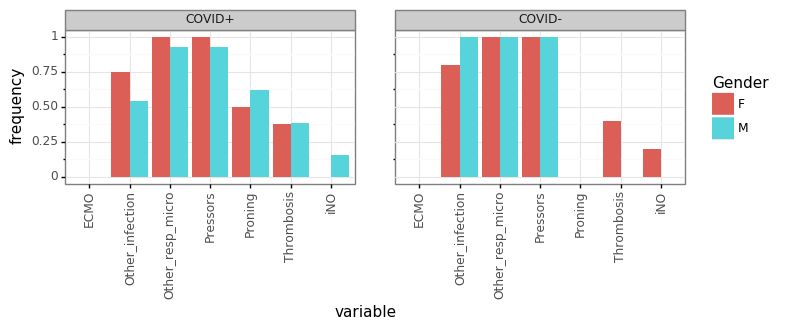

<ggplot: (8758050140597)>


,variable,value,COVID_status_(T/F),Gender,count
9,ECMO,False,COVID+,F,8
23,ECMO,False,COVID+,M,13
37,ECMO,False,COVID-,F,5
51,ECMO,False,COVID-,M,2
8,ECMO,True,COVID+,F,0
22,ECMO,True,COVID+,M,0
36,ECMO,True,COVID-,F,0
50,ECMO,True,COVID-,M,0
7,Other_infection,False,COVID+,F,2
21,Other_infection,False,COVID+,M,6


In [166]:
target_vars = ['Pressors_(T/F)','Proning_(T/F)', 'iNO_(T/F)', 'ECMO_(T/F)', 
               'Thrombosis_(T/F)','Other_infection_(T/F)', 'Other_resp_micro_(T/F)',]
target_vars = [x for x in target_vars if x not in [pivot_1,pivot_2,]]

plot_df = metadata_trimmed.loc[:,[pivot_1,pivot_2]+target_vars]
plot_df.columns = [x.split('_(T/F)')[0] if x not in [pivot_1,pivot_2] else x for x in plot_df.columns]

plot_df = pd.melt(plot_df, id_vars=[pivot_1,pivot_2])
plot_df['variable'] = (plot_df['variable']
                       .astype(str)
                       .astype(CategoricalDtype([x.split('_(T/F)')[0] for x in target_vars], ordered = True)
                              )
                      )
plot_df[pivot_1] = ['COVID+' if x==True else 'COVID-' for x in plot_df[pivot_1]]
display_df = pd.DataFrame(plot_df.groupby([pivot_1,pivot_2,'variable'])['value'].value_counts(normalize=False))
plot_df = pd.DataFrame(plot_df.groupby([pivot_1,pivot_2,'variable'])['value'].value_counts(normalize=True))
plot_df = (plot_df
           .rename(columns={'value':'frequency'})
           .reset_index()
          )

# create dummy categories
base_df = pd.DataFrame()
for x in set(plot_df[pivot_1]):
    for y in set(plot_df[pivot_2]):
        for z in set(plot_df['variable']):
            for zz in [True,False]:
                slice_df = pd.DataFrame({pivot_1:[x],
                                         pivot_2:[y],
                                         'variable':[z],
                                         'value':[zz],
                                        })
                base_df = base_df.append(slice_df)
                
plot_df = pd.merge(base_df, plot_df, 'left', [pivot_1,pivot_2,'variable','value',])
plot_df = plot_df.replace(np.nan, 0)

plotnine.options.figure_size=(8,2)
plot = (ggplot(plot_df[plot_df['value'] == True])
        + theme_bw()
        + theme(panel_spacing_x = 0.4)
        + theme(axis_text_x = element_text(angle = 90))
        + geom_bar(aes('variable','frequency',fill = pivot_2), stat='identity', position='dodge')
        + facet_grid(f'.~{pivot_1}', scales='free')
       )
print(plot)

# tabular output
display_df = pd.merge(base_df, 
                      display_df.rename(columns = {'value':'count'}).reset_index(), 
                      'left', 
                      [pivot_1,pivot_2,'variable','value',])
display_df = display_df.replace(np.nan, 0)
display_df['count'] = display_df['count'].astype(int)
display_df = (display_df
              .loc[:, ['variable','value',pivot_1,pivot_2,'count']]
              .sort_values(['variable','value',pivot_1,pivot_2])
             )
display_df
